<a href="https://colab.research.google.com/github/TaeminDA/portfolio/blob/main/Times_Series_Analysis_with_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Univariate Time Series Forecasting: with RNN

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

***

## Import

In [176]:
ts = pd.read_csv("/content/Ice cream quarterly.csv")
ts.DATE = pd.to_datetime(ts.DATE)

In [178]:
ts.columns = ["Date","Icecream"]

In [184]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      194 non-null    datetime64[ns]
 1   Icecream  194 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.2 KB


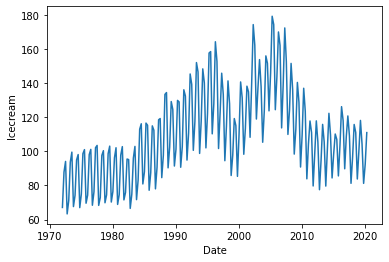

In [182]:
sns.lineplot(x = 'Date', y = 'Icecream', data = ts)

In [183]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_ts = scaler.fit_transform(ts[["Icecream"]])

In [216]:
scaled_ts = scaled_ts.squeeze()

In [233]:
split_time = 120
time_train = ts["Date"][:split_time]
x_train = scaled_ts[:split_time]
time_valid = ts["Date"][split_time:]
x_valid = scaled_ts[split_time:]

## Window for training

In [ ]:
# dataset = tf.data.Dataset.from_tensor_slices(scaled_ts)
# # list(dataset.as_numpy_iterator())

# dataset = dataset.window(10, shift=1, drop_remainder=True)
# # for window in dataset:
# #   print(list(window.as_numpy_iterator()))

# dataset = dataset.flat_map(lambda window: window.batch(10))
# # list(dataset.as_numpy_iterator())

# dataset = dataset.shuffle(100).map(lambda window: (window[:-1], window[-1]))
# # list(dataset.as_numpy_iterator())

# dataset = dataset.batch(8).prefetch(1)
# # list(dataset.as_numpy_iterator())

In [354]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [355]:
# from keras.preprocessing.sequence import TimeseriesGenerator

In [356]:
window_size = 10
batch_size = 16
shuffle_buffer_size = 120

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer = shuffle_buffer_size)

## Forecasting with LSTM

In [357]:
lstm_model = tf.keras.models.Sequential([
                                         tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),
                                         tf.keras.layers.LSTM(64, return_sequences=True),
                                         tf.keras.layers.LSTM(64),
                                         tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam()
lstm_model.compile(loss="mse",
              optimizer=optimizer,
              metrics=["mse"])
lstm_history = lstm_model.fit(dataset, epochs=200, verbose = 0)

In [359]:
lstm_forecast = []
lstm_results = []
for time in range(len(x_valid) - window_size):

  tmp = lstm_model.predict(x_valid[time:time + window_size][np.newaxis])
  lstm_forecast.append(tmp)

lstm_results = np.array(lstm_forecast)[:, 0, 0]

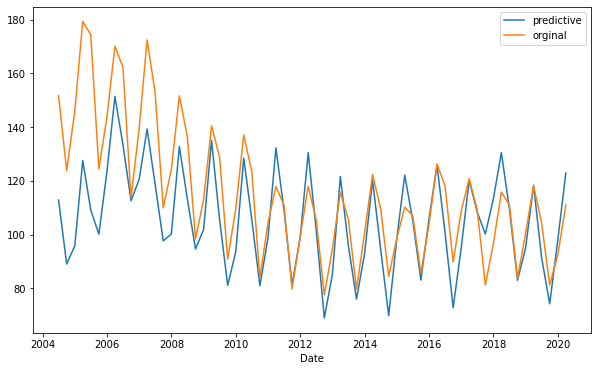

In [360]:
plt.figure(figsize=(10, 6))

lstm_results_or = scaler.inverse_transform([lstm_results]).squeeze()
x_valid_or = scaler.inverse_transform([x_valid]).squeeze()

sns.lineplot(x = time_valid[window_size:],y = lstm_results_or, label="predictive")
sns.lineplot(x = time_valid[window_size:],y = x_valid_or[window_size:], label = "orginal")

## Forecasting with GRU

In [ ]:
gru_model = tf.keras.models.Sequential([
                                        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),
                                        tf.keras.layers.GRU(64, return_sequences=True),
                                        tf.keras.layers.GRU(64),
                                        tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam()
gru_model.compile(loss="mse",
              optimizer=optimizer,
              metrics=["mse"])
gru_history = gru_model.fit(dataset, epochs=200, verbose = 0)

In [361]:
gru_forecast = []
gru_results = []
for time in range(len(x_valid) - window_size):

  tmp = gru_model.predict(x_valid[time:time + window_size][np.newaxis])
  gru_forecast.append(tmp)

gru_results = np.array(gru_forecast)[:, 0, 0]

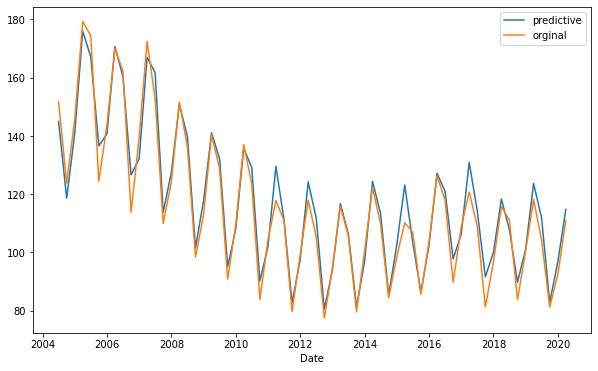

In [362]:
plt.figure(figsize=(10, 6))

gru_results_or = scaler.inverse_transform([gru_results]).squeeze()
x_valid_or = scaler.inverse_transform([x_valid]).squeeze()

sns.lineplot(x = time_valid[window_size:],y = gru_results_or, label="predictive")
sns.lineplot(x = time_valid[window_size:],y = x_valid_or[window_size:], label = "orginal")

## Compare all

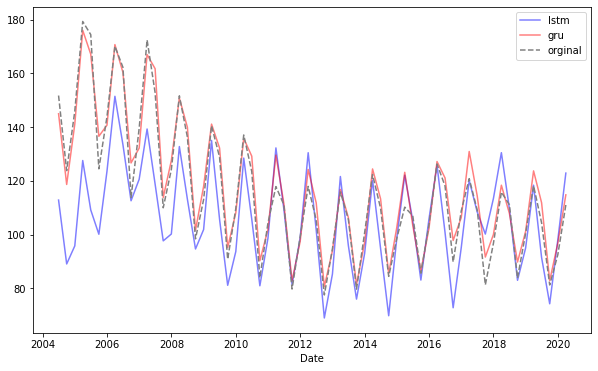

In [363]:
plt.figure(figsize=(10, 6))

sns.lineplot(x = time_valid[window_size:],y = lstm_results_or, label="lstm", color = 'blue', alpha = 0.5)
sns.lineplot(x = time_valid[window_size:],y = gru_results_or, label="gru", color = 'red', alpha = 0.5)
sns.lineplot(x = time_valid[window_size:],y = x_valid_or[window_size:], label = "orginal",linestyle='--', color = 'gray')

***

## Etc

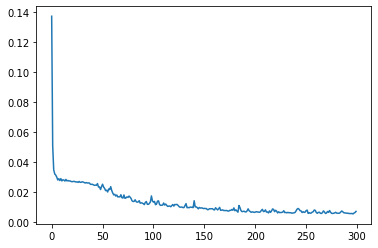

In [352]:
plt.plot(lstm_history.history['mse'])

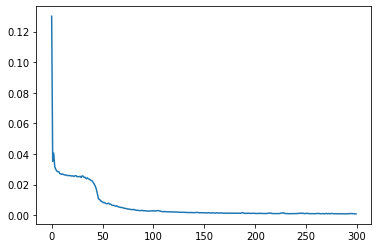

In [353]:
plt.plot(gru_history.history['mse'])

In [364]:
forecast = []
results = []
for time in range(len(scaled_ts) - window_size):

  tmp = gru_model.predict(scaled_ts[time:time + window_size][np.newaxis])
  forecast.append(tmp)

results = np.array(forecast)[:, 0, 0]

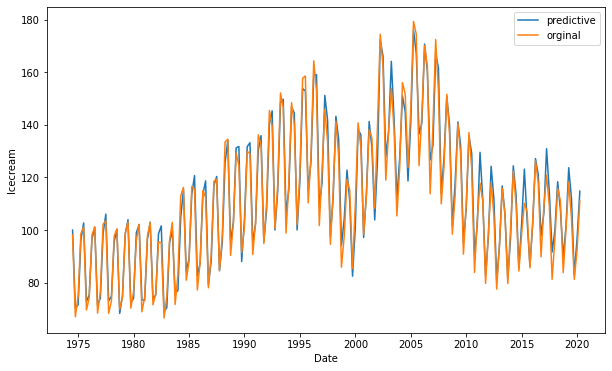

In [365]:
plt.figure(figsize=(10, 6))

results_or = scaler.inverse_transform([results]).squeeze()

sns.lineplot(x = ts["Date"][window_size:],y = results_or, label="predictive")
sns.lineplot(x = ts["Date"][window_size:],y = ts["Icecream"][window_size:], label = "orginal")